# Comparing electron id between nominal and super trigger cells



In [9]:
#imports and setup
%matplotlib inline
%cd /home/naodell/work/hgcal/analysis

import sys, os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm_notebook

import plotly.plotly as plotly
import plotly.graph_objs as go
from plotly.graph_objs import Surface, Mesh3d
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
    
from scripts.helpers import eta_to_theta, propagate_to_face, assign_phi, delta_phi, set_default_style
set_default_style()

%connect_info

/home/naodell/work/hgcal/analysis


{
  "shell_port": 56729,
  "iopub_port": 37387,
  "stdin_port": 49201,
  "control_port": 39151,
  "hb_port": 42123,
  "ip": "127.0.0.1",
  "key": "5b257b42-6d8acc6d5a9068a5fe2cde9f",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-a866f078-cff8-420a-9778-d5dee543c620.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [10]:
# get the data
samples = ['charged_pion_nominal', 'charged_pion_super', 'electron_nominal', 'electron_super']#, 'single_pion_nominal', 'single_pion_super']
evt_data = dict()
for sample in samples:
    #input_dir = f'local_data/{sample}/dataframes'
    #df_list = []
    #for i, filename in enumerate(os.listdir(input_dir)):
    #    infile = open(f'local_data/{sample}/dataframes/{filename}', 'rb')
    infile = open(f'local_data/{sample}/dataframes/output_0.pkl', 'rb')
    evts_particles  = pickle.load(infile)
    evts_cells = pickle.load(infile)
    evts_clusters = pickle.load(infile)
        
    # match particles to clusters
    matched_data = []
    for ievt, particles in tqdm_notebook(enumerate(evts_particles), leave=False):
        if particles.size == 0:
            continue

        clusters = evts_clusters[ievt].query('cl_pt > 5') # this cut is just to get around matching to a low energy cluster

        if 'electron' in sample:
            # match electron 1 to cluster
            electron1 = particles.iloc[0]
            dphi = np.abs(electron1.phi - clusters.cl_phi)
            dphi[dphi > np.pi] = 2*np.pi - dphi[dphi > np.pi]
            deta = np.abs(electron1.eta - clusters.cl_eta)
            dr = np.sqrt(deta**2 + dphi**2)

            cluster1 = clusters.loc[dr.idxmin()]
            matched_data.append(pd.concat([electron1, cluster1]))
            matched_data[-1]['pt_ratio'] = cluster1.cl_pt/electron1.pt
            matched_data[-1]['e_ratio'] = cluster1.cl_e/electron1.e

            # match electron 2 to cluster
            electron2 = particles.iloc[1]
            dphi = np.abs(electron2.phi - clusters.cl_phi)
            dphi[dphi > np.pi] = 2*np.pi - dphi[dphi > np.pi]
            deta = np.abs(electron2.eta - clusters.cl_eta)
            dr = np.sqrt(deta**2 + dphi**2)

            cluster2 = clusters.loc[dr.idxmin()]
            matched_data.append(pd.concat([electron2, cluster2]))
            matched_data[-1]['pt_ratio'] = cluster2.cl_pt/electron2.pt
            matched_data[-1]['e_ratio'] = cluster2.cl_e/electron2.e
        elif 'neutral_pion' in sample:
            if 111 not in particles.pid.values or clusters.shape[0] == 0:
                continue

            # match neutral pion to cluster
            pion = particles.query('pid == 111').iloc[0]
            if 1.5 < abs(pion.eta) < 3.1:
                dphi = np.abs(pion.phi - clusters.cl_phi)
                dphi[dphi > np.pi] = 2*np.pi - dphi[dphi > np.pi]
                deta = np.abs(pion.eta - clusters.cl_eta)
                dr = np.sqrt(deta**2 + dphi**2)

                cluster = clusters.loc[dr.idxmin()]
                matched_data.append(pd.concat([pion, cluster]))
                matched_data[-1]['pt_ratio'] = cluster.cl_pt/pion.pt
                matched_data[-1]['e_ratio'] = cluster.cl_e/pion.e
        elif 'charged_pion' in sample:
            if 211 not in particles.pid.values or clusters.shape[0] == 0:
                continue

            # match neutral pion to cluster
            pion = particles.query('pid == 211').iloc[0]
            if 1.5 < abs(pion.eta) < 3.1:
                dphi = np.abs(pion.phi - clusters.cl_phi)
                dphi[dphi > np.pi] = 2*np.pi - dphi[dphi > np.pi]
                deta = np.abs(pion.eta - clusters.cl_eta)
                dr = np.sqrt(deta**2 + dphi**2)

                cluster = clusters.loc[dr.idxmin()]
                matched_data.append(pd.concat([pion, cluster]))
                matched_data[-1]['pt_ratio'] = cluster.cl_pt/pion.pt
                matched_data[-1]['e_ratio'] = cluster.cl_e/pion.e

    evt_data[sample] = pd.DataFrame(matched_data, index=np.arange(len(matched_data)))
    #    df_list.append(pd.DataFrame(matched_data, index=np.arange(len(matched_data))))
    #evt_data[sample] = pd.concat(df_list)

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



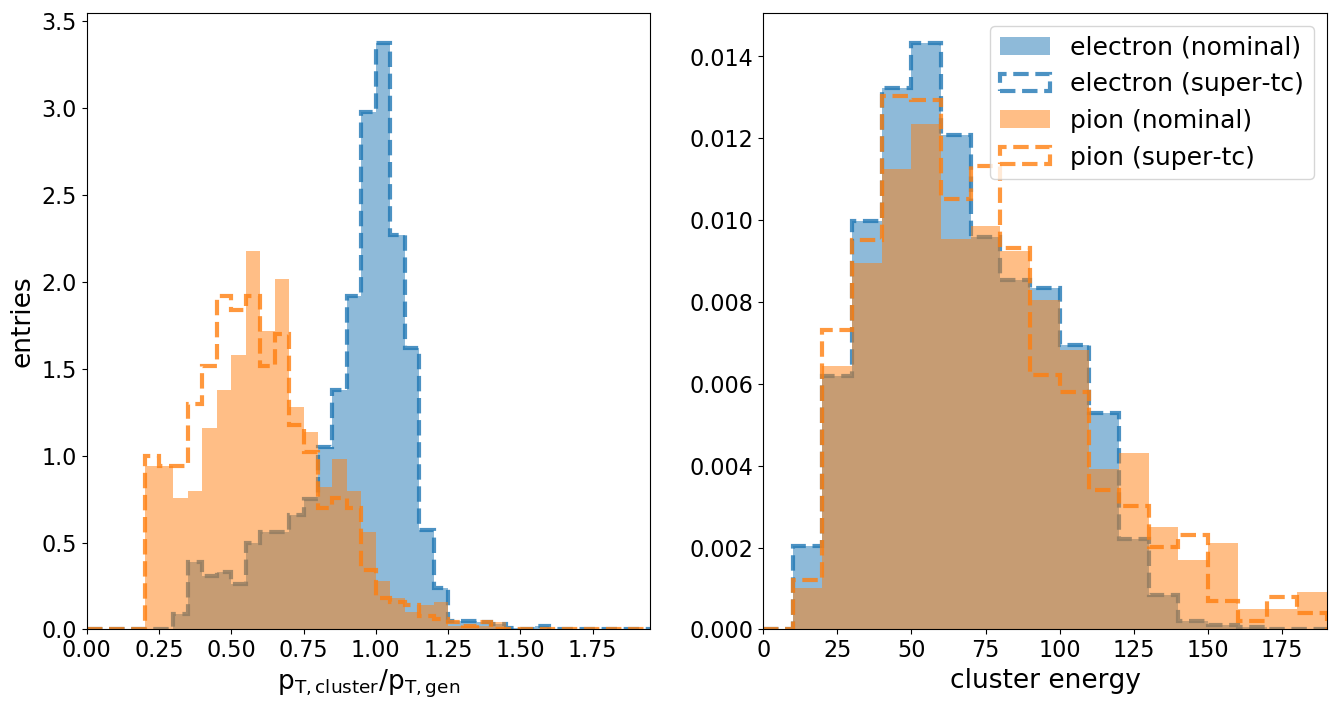

In [11]:
# makes some plots
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=False, facecolor='white')

ax = axes[0]
binning = np.arange(0, 2, 0.05)
ax.hist(evt_data['electron_nominal'].pt_ratio, bins=binning, color='C0', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['electron_super'].pt_ratio, bins=binning, color='C0', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.hist(evt_data['charged_pion_nominal'].pt_ratio, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['charged_pion_super'].pt_ratio, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
#ax.hist(evt_data['neutral_pion_nominal'].pt_ratio, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
#ax.hist(evt_data['neutral_pion_super'].pt_ratio, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.set_xlabel('$\sf p_{T, cluster}/p_{T, gen}$')
ax.set_ylabel('entries')
ax.set_xlim(binning[0], binning[-1])

ax = axes[1]
binning = np.arange(0., 200., 10)
ax.hist(evt_data['electron_nominal'].cl_e, bins=binning, color='C0', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['electron_super'].cl_e, bins=binning, color='C0', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.hist(evt_data['charged_pion_nominal'].cl_e, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['charged_pion_super'].cl_e, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
#ax.hist(evt_data['neutral_pion_nominal'].cl_e, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
#ax.hist(evt_data['neutral_pion_super'].cl_e, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.set_xlabel('cluster energy')
ax.set_xlim(binning[0], binning[-1])

ax.legend(['electron (nominal)', 'electron (super-tc)', 'pion (nominal)', 'pion (super-tc)'])

plt.savefig('plots/kinematics.png')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



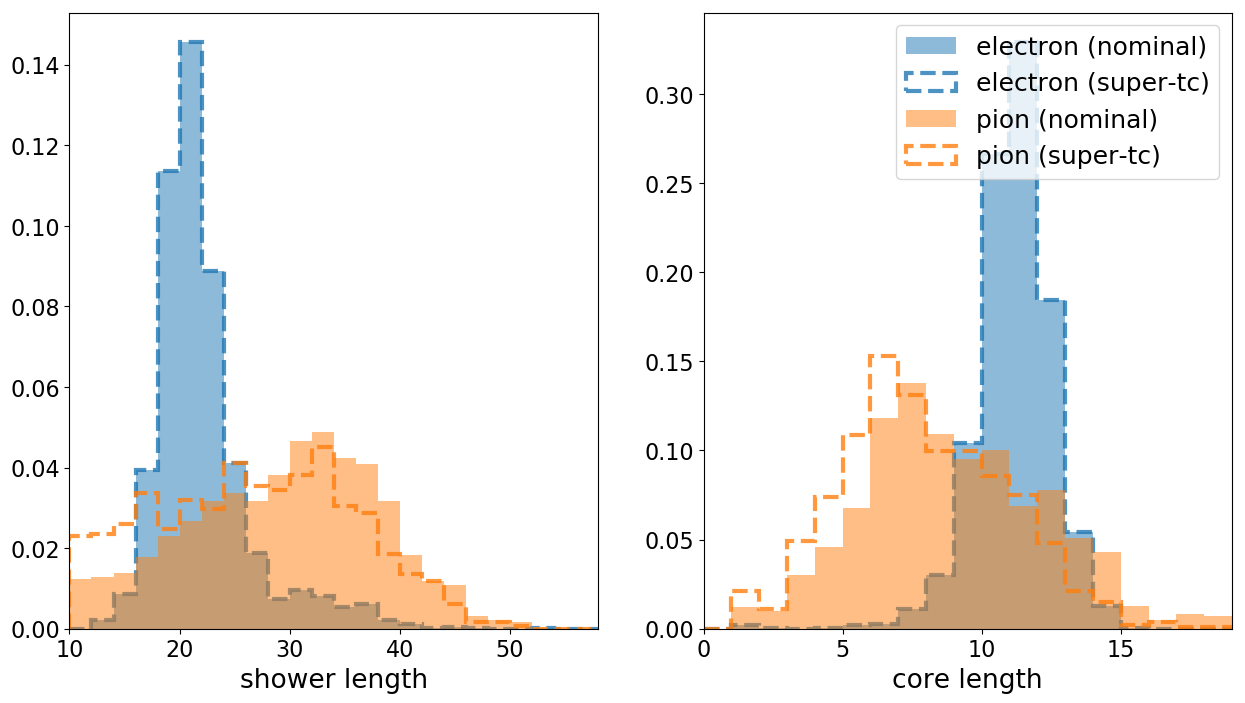

In [12]:
# shower length
fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=False, facecolor='white')

ax = axes[0]
binning = np.arange(10., 60., 2)
ax.hist(evt_data['electron_nominal'].showerlength, bins=binning, color='C0', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['electron_super'].showerlength, bins=binning, color='C0', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.hist(evt_data['charged_pion_nominal'].showerlength, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['charged_pion_super'].showerlength, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
#ax.hist(evt_data['neutral_pion_nominal'].showerlength, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
#ax.hist(evt_data['neutral_pion_super'].showerlength, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.set_xlabel('shower length')
ax.set_xlim(binning[0], binning[-1])

ax = axes[1]
binning = np.arange(0., 20., 1)
ax.hist(evt_data['electron_nominal'].corelength, bins=binning, color='C0', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['electron_super'].corelength, bins=binning, color='C0', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.hist(evt_data['charged_pion_nominal'].corelength, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['charged_pion_super'].corelength, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
#ax.hist(evt_data['neutral_pion_nominal'].corelength, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
#ax.hist(evt_data['neutral_pion_super'].corelength, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.set_xlabel('core length')
ax.set_xlim(binning[0], binning[-1])

ax.legend(['electron (nominal)', 'electron (super-tc)', 'pion (nominal)', 'pion (super-tc)'])
plt.savefig('plots/shower_length.png')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



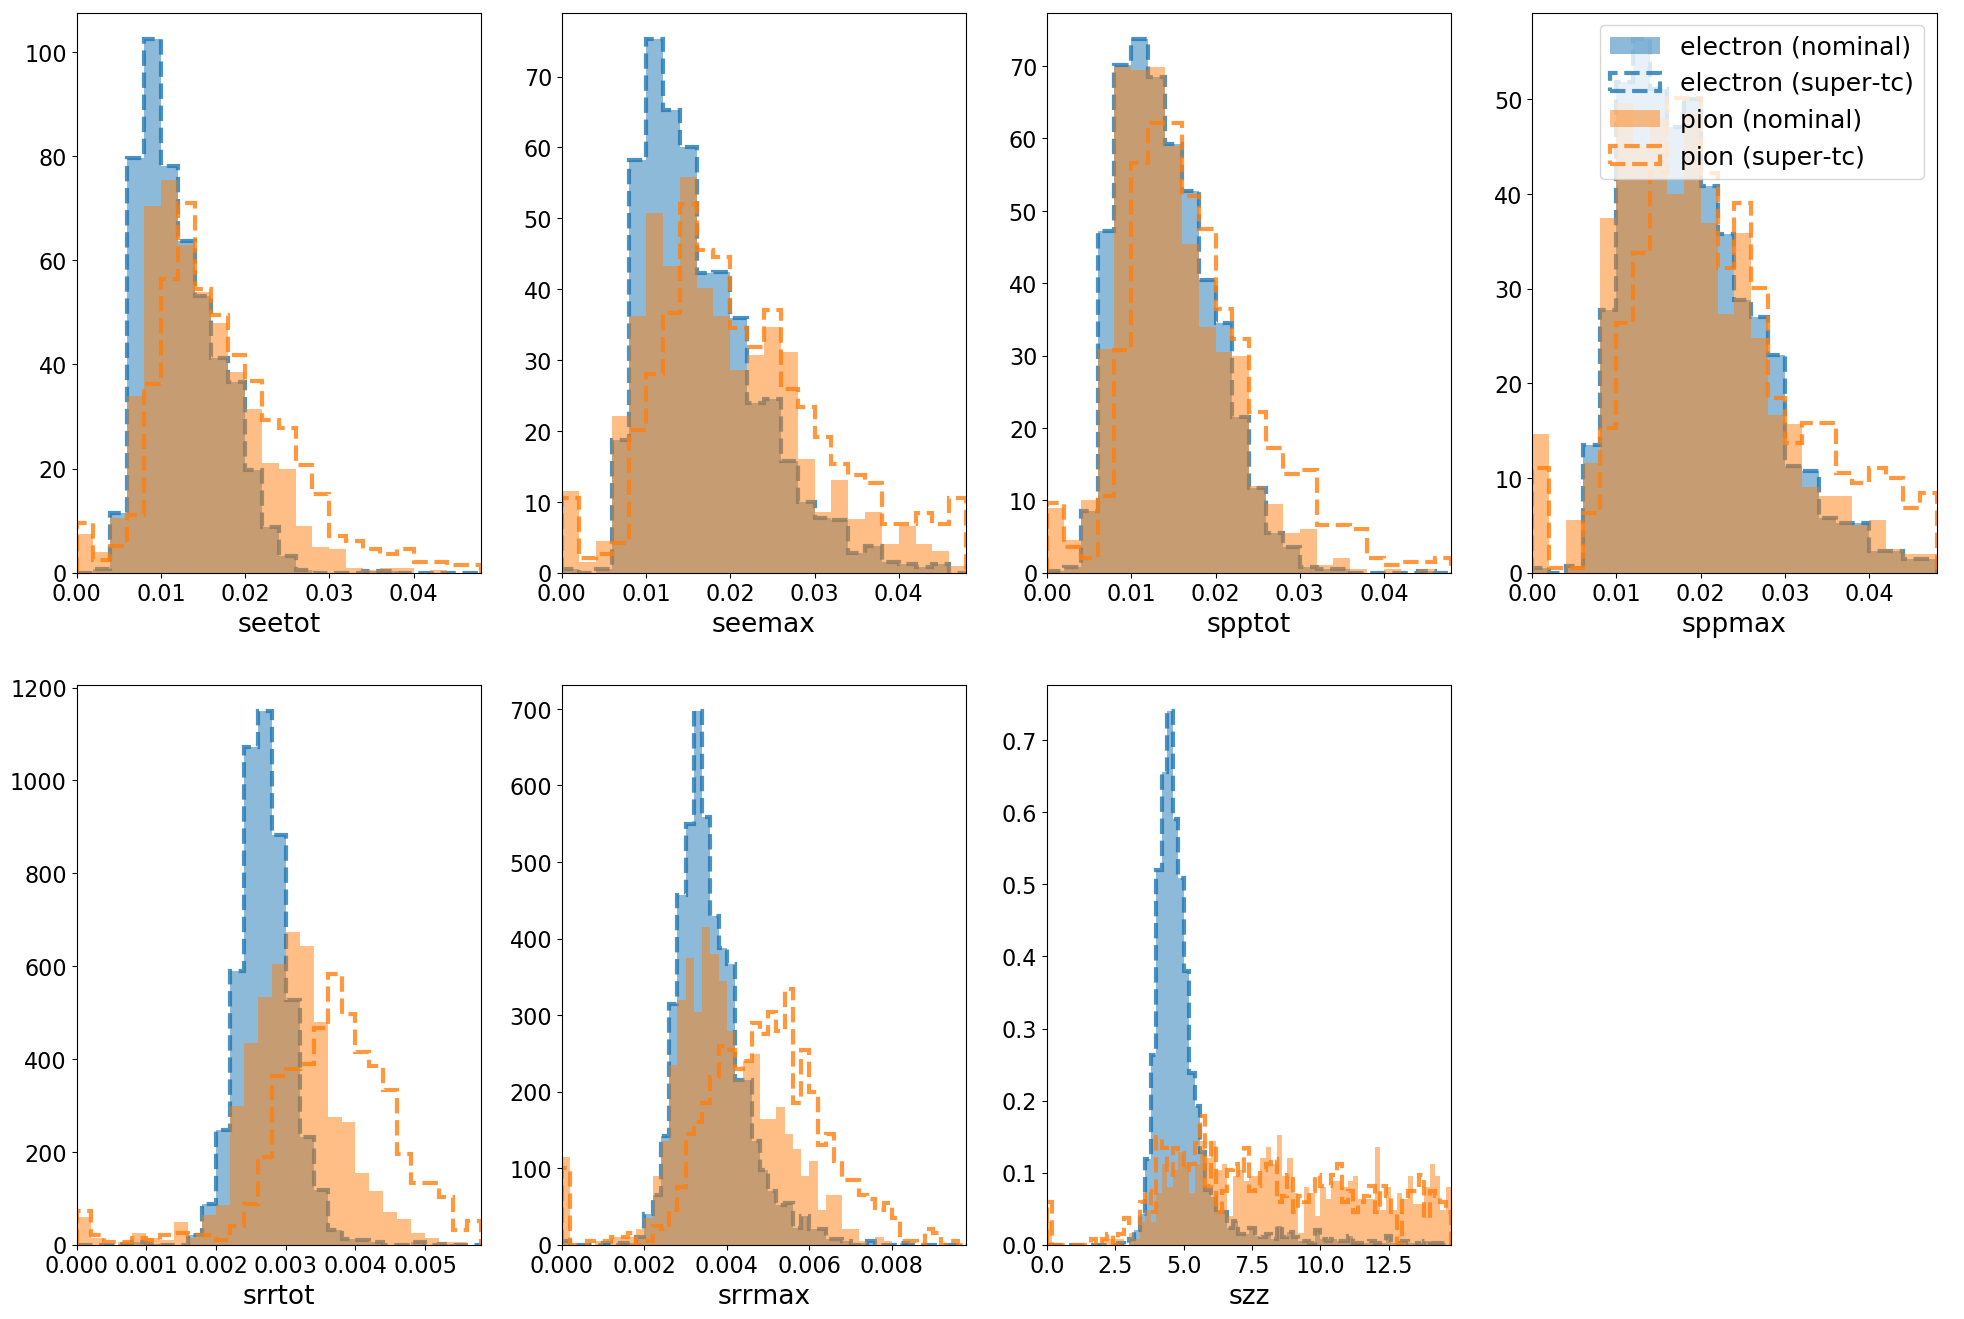

In [13]:
# widths
fig, axes = plt.subplots(2, 4, figsize=(24, 16), sharey=False, facecolor='white')

ax = axes[0][0]
binning = np.arange(0., 0.05, 0.002)
ax.hist(evt_data['electron_nominal'].seetot, bins=binning, color='C0', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['electron_super'].seetot, bins=binning, color='C0', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.hist(evt_data['charged_pion_nominal'].seetot, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['charged_pion_super'].seetot, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.set_xlabel('seetot')
ax.set_xlim(binning[0], binning[-1])

ax = axes[0][1]
binning = np.arange(0., 0.05, 0.002)
ax.hist(evt_data['electron_nominal'].seemax, bins=binning, color='C0', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['electron_super'].seemax, bins=binning, color='C0', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.hist(evt_data['charged_pion_nominal'].seemax, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['charged_pion_super'].seemax, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.set_xlabel('seemax')
ax.set_xlim(binning[0], binning[-1])

ax = axes[0][2]
binning = np.arange(0., 0.05, 0.002)
ax.hist(evt_data['electron_nominal'].spptot, bins=binning, color='C0', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['electron_super'].spptot, bins=binning, color='C0', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.hist(evt_data['charged_pion_nominal'].spptot, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['charged_pion_super'].spptot, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.set_xlabel('spptot')
ax.set_xlim(binning[0], binning[-1])

ax = axes[0][3]
binning = np.arange(0., 0.05, 0.002)
ax.hist(evt_data['electron_nominal'].sppmax, bins=binning, color='C0', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['electron_super'].sppmax, bins=binning, color='C0', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.hist(evt_data['charged_pion_nominal'].sppmax, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['charged_pion_super'].sppmax, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.set_xlabel('sppmax')
ax.set_xlim(binning[0], binning[-1])

ax.legend(['electron (nominal)', 'electron (super-tc)', 'pion (nominal)', 'pion (super-tc)'])

ax = axes[1][0]
binning = np.arange(0., 0.006, 0.0002)
ax.hist(evt_data['electron_nominal'].srrtot, bins=binning, color='C0', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['electron_super'].srrtot, bins=binning, color='C0', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.hist(evt_data['charged_pion_nominal'].srrtot, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['charged_pion_super'].srrtot, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.set_xlabel('srrtot')
ax.set_xlim(binning[0], binning[-1])

ax = axes[1][1]
binning = np.arange(0., 0.01, 0.0002)
ax.hist(evt_data['electron_nominal'].srrmax, bins=binning, color='C0', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['electron_super'].srrmax, bins=binning, color='C0', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.hist(evt_data['charged_pion_nominal'].srrmax, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['charged_pion_super'].srrmax, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.set_xlabel('srrmax')
ax.set_xlim(binning[0], binning[-1])

ax = axes[1][2]
binning = np.arange(0., 15., 0.2)
ax.hist(evt_data['electron_nominal'].szz, bins=binning, color='C0', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['electron_super'].szz, bins=binning, color='C0', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.hist(evt_data['charged_pion_nominal'].szz, bins=binning, color='C1', histtype='stepfilled', lw=2, alpha=0.5, normed=True)
ax.hist(evt_data['charged_pion_super'].szz, bins=binning, color='C1', linestyle='--', histtype='step', lw=3, alpha=0.8, normed=True)
ax.set_xlabel('szz')
ax.set_xlim(binning[0], binning[-1])

axes[1][3].axis('off')

plt.savefig('plots/sigma_dist.png')
plt.show()